<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Panel_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [120]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import Input, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Normalization
from sklearn.metrics import mean_squared_error
plt.rc("figure", figsize=(20,8))
plt.rc("font", size=14)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/MGTF 405/gkx_merged.csv')
df=df.iloc[:,1:]

In this dataframe we collect data from the GKX(2020) paper and merge it with CRSP's Returns data. The variable "permno" is the firms unique identifier.

In [3]:
len(df['permno'].unique())

3366

The "DATE" variable shows date in human readable form, the "date_cat" variable is date in terms of time periods. We will use the "date_cat" for looping.

In [4]:
min(df['DATE']), max(df['DATE'])

('1985-01-31', '2021-12-31')

(-1.0, 1.0)

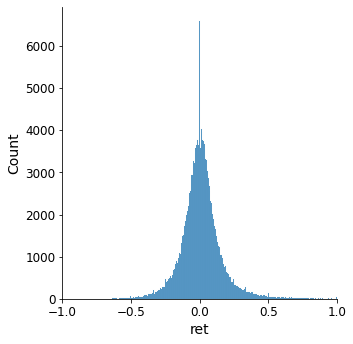

In [121]:
sns.displot(data=df,x='ret',kind='hist')
plt.xlim((-1,1))

## The Feature Matrix

In [6]:
pd.DataFrame(np.array(df.drop(['permno','DATE','date_cat','sic2','ret'],axis=1).columns).reshape((47,2)))

,0,1
0,mvel1,beta
1,betasq,chmom
2,dolvol,idiovol
3,indmom,mom1m
4,mom6m,mom12m
5,mom36m,pricedelay
6,turn,absacc
7,acc,age
8,agr,bm
9,bm_ia,cashdebt


# Feed-Forward Neural Networks

The purpose is to develop a neural network model which will take into account all stocks, and forecast all stocks in the dataframe.

In [7]:
y=df['ret']
X=df.drop(['ret','DATE','sic2','permno'],axis=1)

In [8]:
len(X)==len(y)

True

GKX show that a neural net with 3 hidden layer seem to perform best amongst the data tested. We will define a model with different potential hyperparamters.

In [9]:
import typing

class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)



In [10]:
scalermin=SklearnWrapper(MinMaxScaler(feature_range=(-1,1)))

In [11]:
x_tr=X.groupby('date_cat').apply(scalermin.fit_transform).drop(['date_cat'],axis=1)

In [12]:
X_tr=pd.concat((x_tr,X['date_cat']),axis=1)

In [13]:
max(X_tr['date_cat'])

779

In [14]:
X_train=X_tr[X_tr['date_cat']<=777].drop('date_cat',axis=1)
X_val=X_tr[X_tr['date_cat']==778].drop('date_cat',axis=1)
X_test=X_tr[X_tr['date_cat']==779].drop('date_cat',axis=1)

In [15]:
y_train=y[:204750]
y_val=y[204750:205413]
y_test=y[205413:]

In [16]:
X_new=pd.concat((X_train,X_val),axis=0)
y_new=pd.concat((y_train,y_val),axis=0)

In [30]:
# Set the Patience Level of Early Stopping
# Iterations increase with patience

#patience =2
#patience =3
#patience =4
#patience =5
patience =6
#patience =7
#patience =8

early_stop = EarlyStopping(monitor='val_loss',patience=patience)

In [32]:
output_dict={}

In [58]:
def panel_deep_neuralnets(n1,n2,n3,loss,opt,act_fn,es=False):
  prediction_train=[]
  prediction_test=[]
  oosr2=[]
  if es:
    normalizer=Normalization(axis=-1)
    model=Sequential(normalizer)
    model.add(Dense(n1,activation=act_fn))
    model.add(Dense(n2,activation=act_fn))
    model.add(Dense(n3,activation=act_fn))
    model.add(Dense(1))
    model.compile(loss=loss,optimizer=opt)
    model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=200,callbacks=[early_stop])
  else:
    normalizer=Normalization(axis=-1)
    model=Sequential(normalizer)
    model.add(Dense(n1,activation=act_fn))
    model.add(Dense(n2,activation=act_fn))
    model.add(Dense(n3,activation=act_fn))
    model.add(Dense(1))
    model.compile(loss=loss,optimizer=opt)
    model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=200)

  prediction_train = model.predict(X_new)
  prediction_test=model.predict(X_test)
  benchmark=np.zeros
  oosr2=1-(mean_squared_error(y_test,prediction_test)/mean_squared_error(y_test,pd.DataFrame(np.zeros(len(y_test)))))
  output_dict['nn3'+'_['+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+loss+'_'+opt+'_'+act_fn+'_'+str(es)+']']={}
  output_dict['nn3'+'_['+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+loss+'_'+opt+'_'+act_fn+'_'+str(es)+']']['In Sample Prediction']=prediction_train
  output_dict['nn3'+'_['+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+loss+'_'+opt+'_'+act_fn+'_'+str(es)+']']['Forecast']=prediction_test
  output_dict['nn3'+'_['+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+loss+'_'+opt+'_'+act_fn+'_'+str(es)+']']['OOSR2']=oosr2
  



In [73]:
output_dict={}

In [74]:
panel_deep_neuralnets(32,16,8,'huber','adam','relu',es=True)
panel_deep_neuralnets(32,16,8,'huber','adam','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'huber','adam','selu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','relu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','selu',es=True)

panel_deep_neuralnets(32,16,8,'huber','adam','relu',es=True)
panel_deep_neuralnets(32,16,8,'huber','adam','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'huber','adam','selu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','relu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','adam','selu',es=True)

panel_deep_neuralnets(32,16,8,'huber','ftrl','relu',es=True)
panel_deep_neuralnets(32,16,8,'huber','ftrl','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'huber','ftrl','selu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','ftrl','relu',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','ftrl','sigmoid',es=True)
panel_deep_neuralnets(32,16,8,'mean_squared_error','ftrl','selu',es=True)


Epoch 1/200
6399/6399 [==============================] - 14s 2ms/step - loss: 0.0137 - val_loss: 0.0115
Epoch 2/200
6399/6399 [==============================] - 12s 2ms/step - loss: 0.0136 - val_loss: 0.0118
Epoch 3/200
6399/6399 [==============================] - 13s 2ms/step - loss: 0.0135 - val_loss: 0.0115
Epoch 4/200
6399/6399 [==============================] - 12s 2ms/step - loss: 0.0135 - val_loss: 0.0118
Epoch 5/200
6399/6399 [==============================] - 13s 2ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 6/200
6399/6399 [==============================] - 12s 2ms/step - loss: 0.0134 - val_loss: 0.0116
Epoch 7/200
6399/6399 [==============================] - 13s 2ms/step - loss: 0.0134 - val_loss: 0.0117
Epoch 8/200
6399/6399 [==============================] - 12s 2ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 9/200
6399/6399 [==============================] - 13s 2ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 10/200
6399/6399 [==============================] - 13s 2m

In [75]:
import pickle

In [76]:
with open('NN_output.pickle', 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=4)

In [77]:
oosr2_list=[]
for i in output_dict.keys():
  oosr2_list.append(output_dict[i]['OOSR2'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

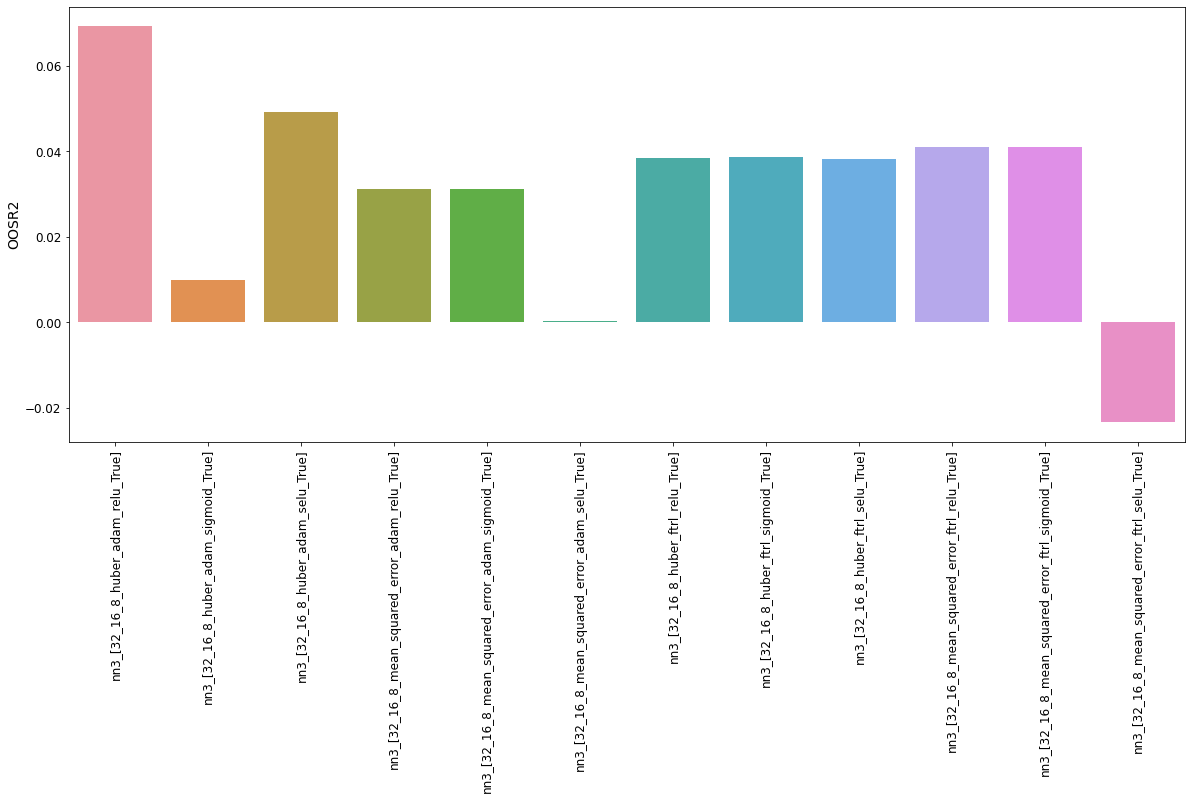

In [122]:
df_oosr2=pd.DataFrame(oosr2_list).set_index(pd.Series(output_dict.keys()))
df_oosr2.columns=['OOSR2']
sns.barplot(data=df_oosr2,x=df_oosr2.index,y='OOSR2')
plt.xticks(rotation=(90))

In [88]:
output_dict.keys()

dict_keys(['nn3_[32_16_8_huber_adam_relu_True]', 'nn3_[32_16_8_huber_adam_sigmoid_True]', 'nn3_[32_16_8_huber_adam_selu_True]', 'nn3_[32_16_8_mean_squared_error_adam_relu_True]', 'nn3_[32_16_8_mean_squared_error_adam_sigmoid_True]', 'nn3_[32_16_8_mean_squared_error_adam_selu_True]', 'nn3_[32_16_8_huber_ftrl_relu_True]', 'nn3_[32_16_8_huber_ftrl_sigmoid_True]', 'nn3_[32_16_8_huber_ftrl_selu_True]', 'nn3_[32_16_8_mean_squared_error_ftrl_relu_True]', 'nn3_[32_16_8_mean_squared_error_ftrl_sigmoid_True]', 'nn3_[32_16_8_mean_squared_error_ftrl_selu_True]'])

In [110]:
df_forecast=pd.DataFrame(output_dict['nn3_[32_16_8_huber_adam_relu_True]']['Forecast'])
forecast_list=[]
for i in output_dict.keys():
  df_forecast=pd.concat((df_forecast,pd.DataFrame(output_dict[i]['Forecast'])),axis=1)
df_forecast=df_forecast.iloc[:,1:]
df_forecast=df_forecast.T.set_index(pd.Series(output_dict.keys())).T
df_forecast=pd.concat((df_forecast,y_test.reset_index(drop=True)),axis=1)

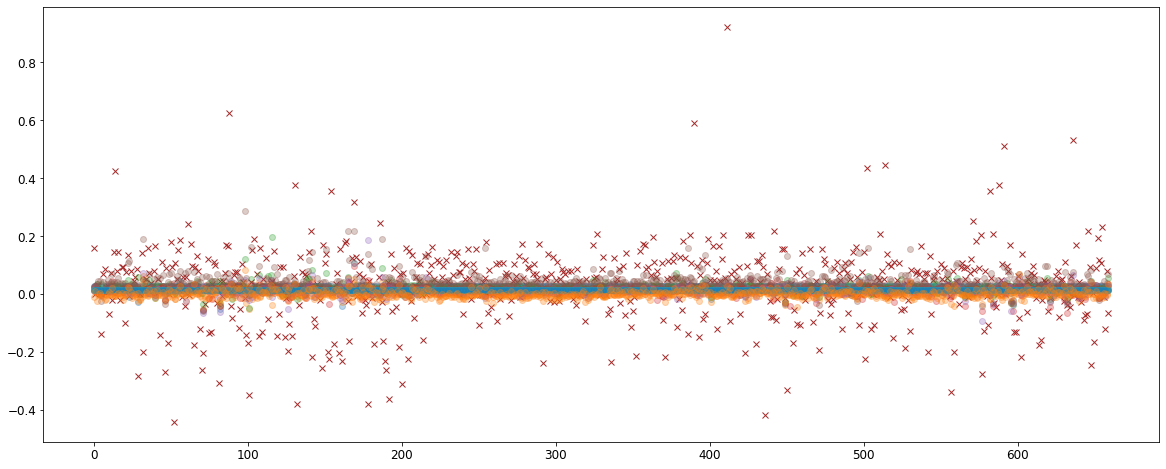

In [128]:
plt.plot(df_forecast['ret'],color='brown',marker='x', linestyle='')
plt.plot(df_forecast.drop('ret',axis=1),marker='o', linestyle='',alpha=0.3)